In [15]:
from IPython.display import display, clear_output
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, top_bot_25, train
from plots import plot_preprocessing, plot_sample_durations, plot_eeg_gradcpt_time_diff

eeg_data_1 = pd.read_csv('data/subject10/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv('data/subject10/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv('data/subject10/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv('data/subject10/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv('data/subject10/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv('data/subject10/gradcpt-session1-3.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

In [16]:
# Sync trial start and end times

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3], ignore_index=True)

### z-normalization

In [17]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Remove artifacts

In [18]:
for channel in channels:
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_normal'])

### Bandpass

In [19]:
for channel in channels:
    eeg_data[f'{channel}_bandpassed'] = bandpass(eeg_data[f'{channel}_artif_removed'])

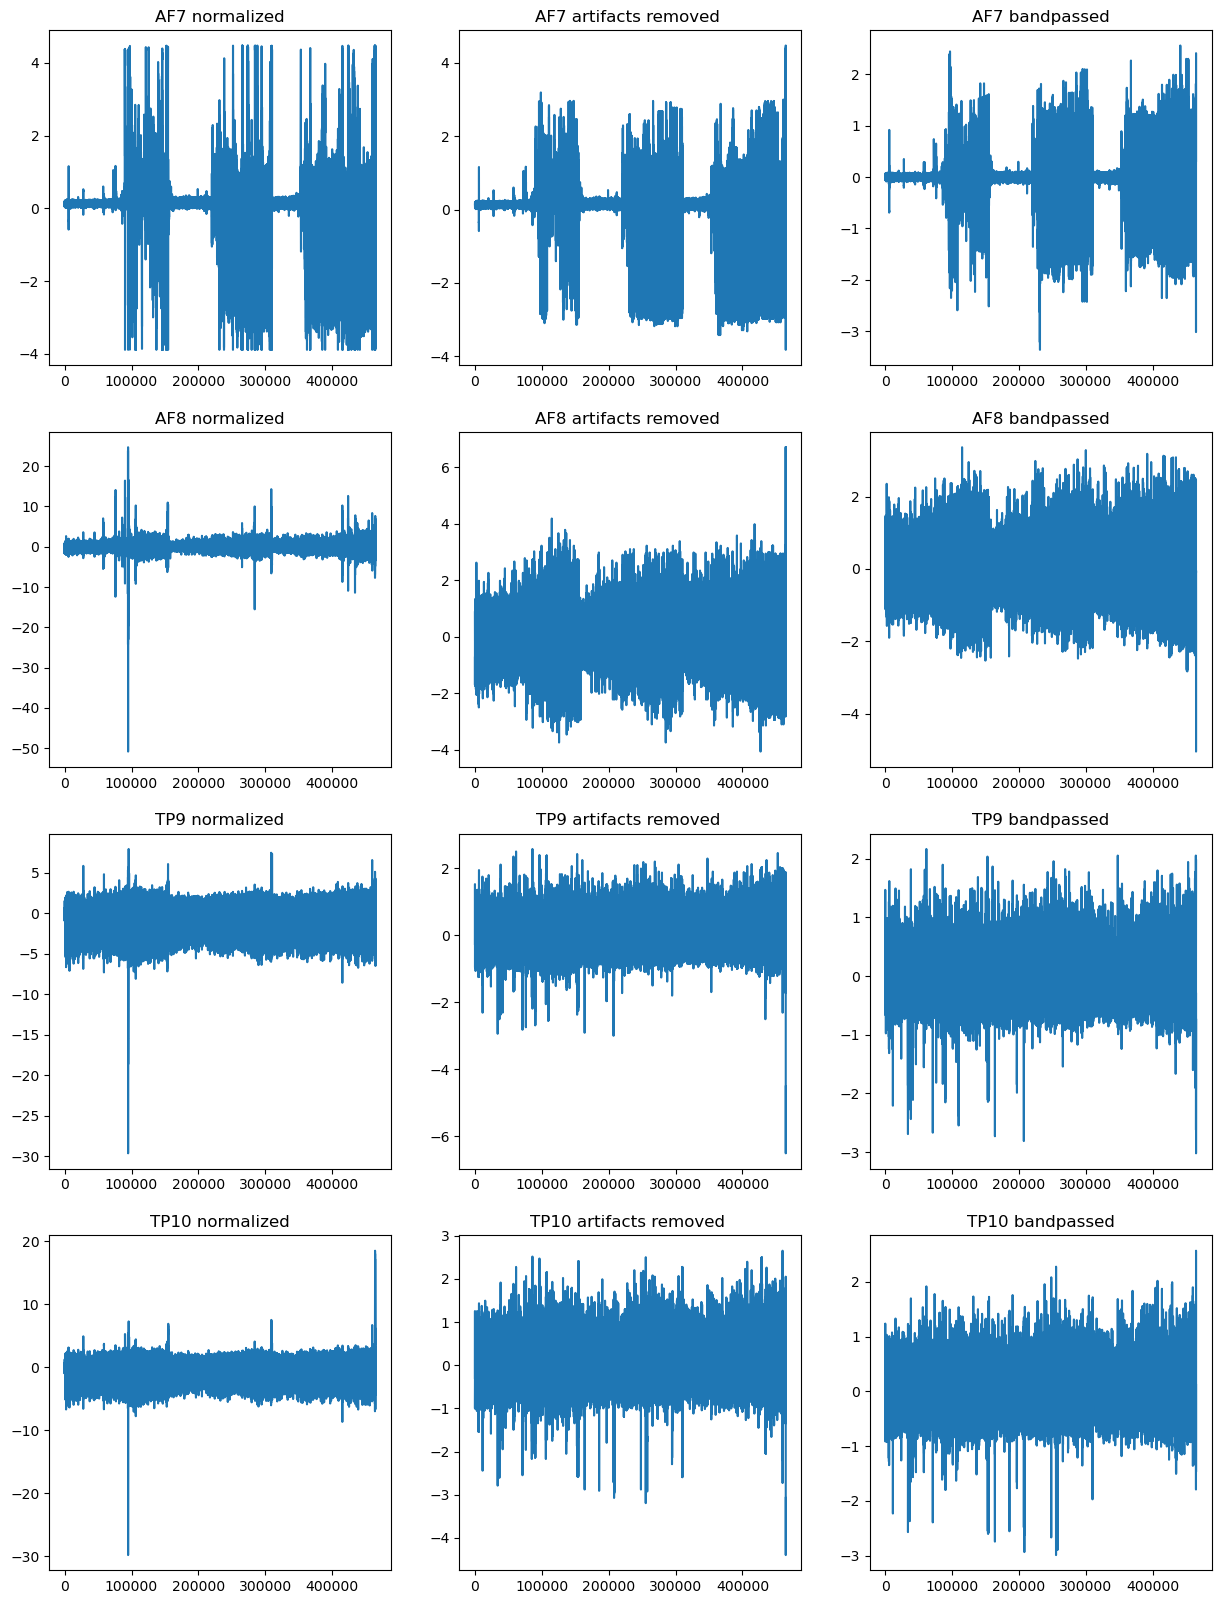

In [20]:
plot_preprocessing(channels=channels, eeg_df=eeg_data)

### Separate trials

In [21]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = eeg_data[eeg_data['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = eeg_data[eeg_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = eeg_data[eeg_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

### Time differences in trials

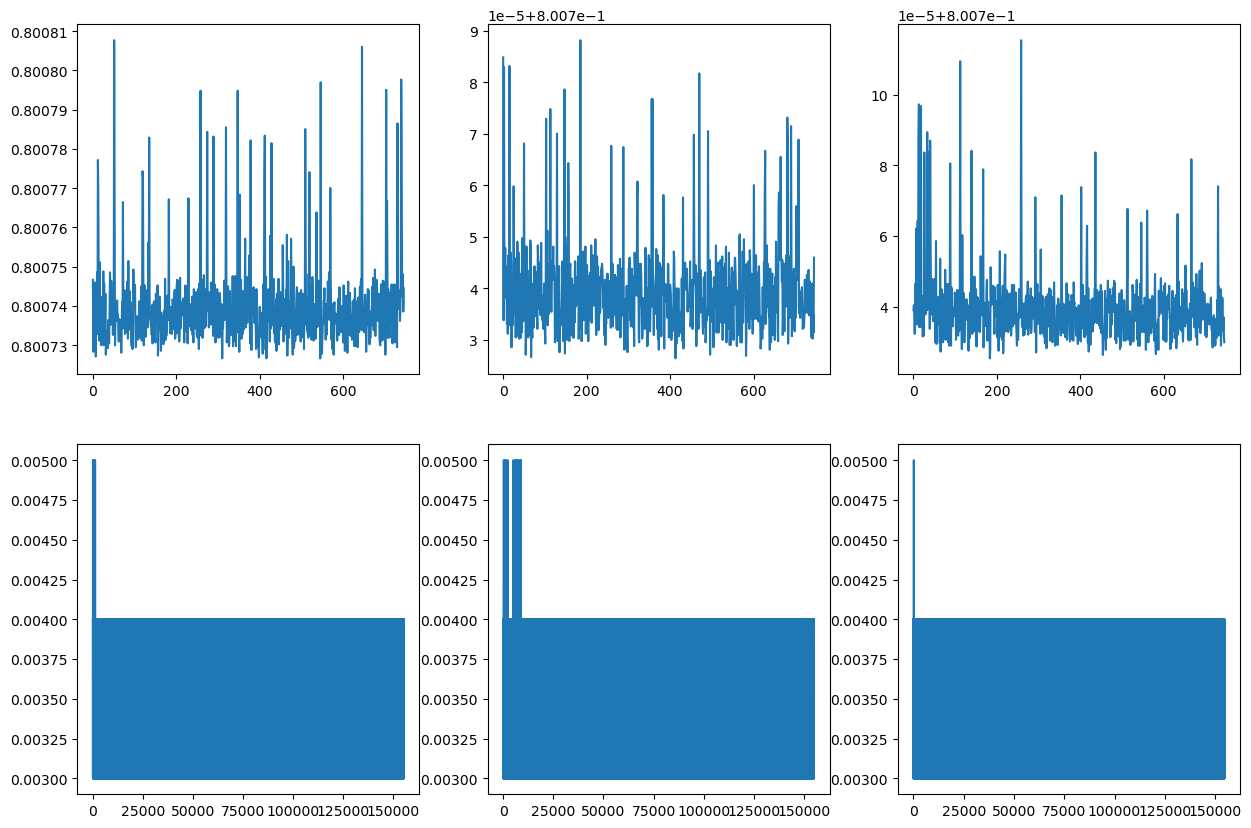

In [22]:
eeg_trials = [eeg_data_t1, eeg_data_t2, eeg_data_t3]
gradcpt_trials = [gradcpt_data_t1, gradcpt_data_t2, gradcpt_data_t3]
plot_sample_durations(eeg_trials, gradcpt_trials)

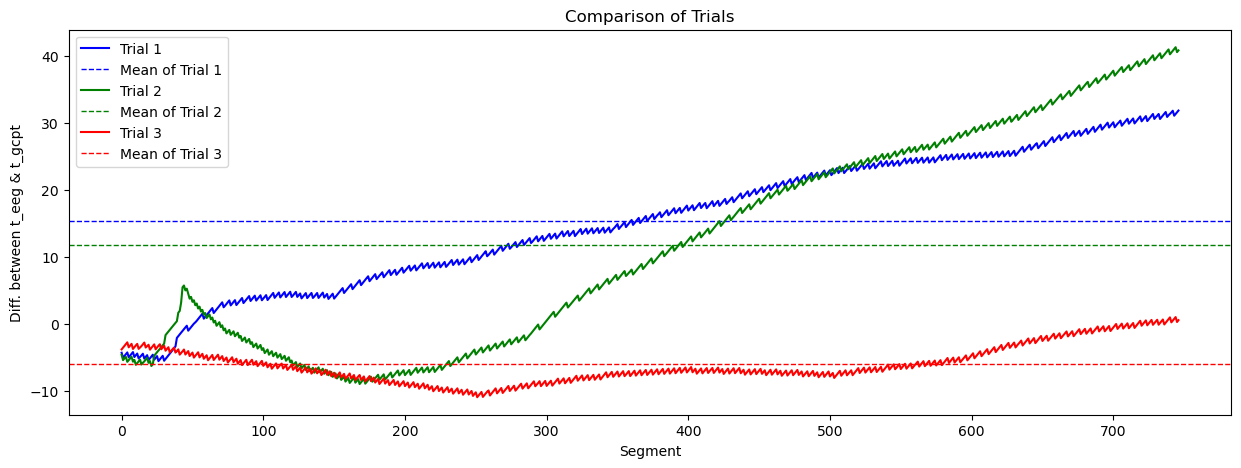

In [23]:
plot_eeg_gradcpt_time_diff(eeg_trials, gradcpt_trials)

### Extract features

In [24]:
# Initialize empty DataFrames for each trial
features_t1 = pd.DataFrame()
features_t2 = pd.DataFrame()
features_t3 = pd.DataFrame()

for trial in [1, 2, 3]:
    # Select the current trial data
    if trial == 1:
        cur_eeg_df = eeg_data_t1
        cur_gcpt_df = gradcpt_data_t1
    elif trial == 2:
        cur_eeg_df = eeg_data_t2
        cur_gcpt_df = gradcpt_data_t2
    else:
        cur_eeg_df = eeg_data_t3
        cur_gcpt_df = gradcpt_data_t3
    
    # Process each channel
    for i, channel in enumerate(channels):
        # Segment the current EEG data
        segments = segment_column(cur_eeg_df[f'{channel}_bandpassed'], cur_gcpt_df)
        # Decompose each segment
        segment_bands = [decompose_segment(segment) for segment in segments]
        # Extract features from the decomposed segments
        features = extract_features(channel, segment_bands)
        
        # Append the features to the respective DataFrame
        if trial == 1:
            features_t1 = pd.concat([features_t1, features], axis=1)
        elif trial == 2:
            features_t2 = pd.concat([features_t2, features], axis=1)
        else:
            features_t3 = pd.concat([features_t3, features], axis=1)
        
        clear_output(wait=True)
        print(f'{(trial-1)*len(channels)+i+1}/{3*len(channels)} Done')

features_t1['in_the_zone'] = gradcpt_data_t1['in_the_zone']
features_t2['in_the_zone'] = gradcpt_data_t2['in_the_zone']
features_t3['in_the_zone'] = gradcpt_data_t3['in_the_zone']

12/12 Done


In [25]:
combined_features_df = pd.concat([features_t1, features_t2, features_t3], ignore_index=True)

## Detach rocket

### Train and eval

In [26]:
from detach_rocket.detach_rocket.detach_classes import DetachMatrix
from sklearn.model_selection import train_test_split

X = combined_features_df.iloc[:, :-1]
y = combined_features_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

detach_matrix = DetachMatrix(trade_off=0.1)
detach_matrix.fit(X_train, y_train)

# Evaluate Performance on Test Set
detach_test_score, full_test_score= detach_matrix.score(X_test, y_test)
print('Test Accuraccy Full Model: {:.2f}%'.format(100*full_test_score))
print('Test Accuraccy Detach Model: {:.2f}%'.format(100*detach_test_score))

TRAINING RESULTS Full Features:
Optimal Alpha Full Features: 54555.95
Train Accuraccy Full Features: 62.76%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 30.00
Train Accuraccy Detach Model: 75.05%
-------------------------
Test Accuraccy Full Model: 66.77%
Test Accuraccy Detach Model: 59.35%


### Plot SFD Curve and Optimal Model selection

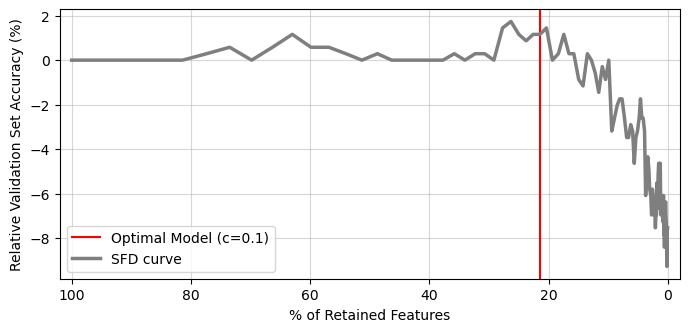

Optimal Model Size: 21.45% of full model


In [27]:
import matplotlib.pyplot as plt
percentage_vector = detach_matrix._percentage_vector
acc_curve = detach_matrix._sfd_curve

c = detach_matrix.trade_off

x_sfd=(percentage_vector) * 100
y_sfd=(acc_curve/acc_curve[0]-1) * 100

point_x = x_sfd[detach_matrix._max_index]
#point_y = y[DetachMatrixModel._max_index]

plt.figure(figsize=(8,3.5))
plt.axvline(x = point_x, color = 'r',label=f'Optimal Model (c={c})')
plt.plot(x_sfd, y_sfd, label='SFD curve', linewidth=2.5, color='C7', alpha=1)
#plt.scatter(point_x, point_y, s=50, marker='o', label=f'Optimal point (c={c})')

plt.grid(True, linestyle='-', alpha=0.5)
plt.xlim(102,-2)
plt.xlabel('% of Retained Features')
plt.ylabel('Relative Validation Set Accuracy (%)')
plt.legend()
plt.show()

print('Optimal Model Size: {:.2f}% of full model'.format(point_x))

### Keep the optimal features

In [28]:
if hasattr(detach_matrix, '_feature_mask'):
    feature_mask = detach_matrix._feature_mask
    
    selected_features_df = X.loc[:, feature_mask]
    selected_features_df = selected_features_df.assign(Label=y)
else:
    print("Feature mask not found in DetachMatrix object.")

### Train the model

In [29]:
n_features = len(selected_features_df.columns)-1 # last col is the label
for feats in [1, 10, 25, 50, 75, 100, n_features]:
    print(f'---{feats} FEATURES---')
    print(train(runs=5, num_features=feats, df=selected_features_df))

---1 FEATURES---
56.2
---10 FEATURES---
56.58
---25 FEATURES---
58.94
---50 FEATURES---
59.76
---75 FEATURES---
59.92
---100 FEATURES---
60.52
---497 FEATURES---
64.86
